
Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>`

**Адаптивный перевод**: `Разработчик профиля "Большие данные и машинное обучение" Олимпиады НТИ Зуева Надежда <https://github.com/nestyme>`

Введение
------------

В этом ноутбуке объясняется и показывается на примерах, как работает алгоритм переноса стиля: 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано этим художником:



**Как это работает?**


Основной принцип заключается в том, что мы определяем два расстояния, одно для контента
($ D_C $) и одно для стиля ($ D_S $). С помощью $ D_C $ мы определяем меру
различия контента между двумя изображениями, а $ D_S $
характеризует, как отличается стиль между двумя изображениями. 

И тогда мы возьмем третье изображение на вход (например, с шумом) и преобразуем его таким образом, чтобы минимизировать его отличие от контента и стиля.

Начнем по порядку.

Подключим необходимые нам библиотеки. 

Во-первых, библиотека для работы с изображениями.
Во-вторых, библиотека для построения изображений по точкам. Для того, чтобы изображения показывались прям в ноутбуке вставляем соответствующую строку "%matplotlib inline"

И далее библиотеки для реализации алгоритма переноса Pytorch, а также вспомогательная библиотека.

# №1 Загрузка изображений

In [1]:
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/picasso.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/dancing.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/cloud.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/scream.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/emc.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/kon.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/les.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/vangog001.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/vangog002.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/vangog003.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/mone001.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/mone002.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/kandi001.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/kandi002.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/levitan001.jpg
!wget https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/levitan002.jpg
!ls

--2019-09-17 06:27:18--  https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/picasso.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.04s   

2019-09-17 06:27:18 (2.97 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2019-09-17 06:27:19--  https://raw.githubusercontent.com/evilfaust/NTI_lesson/master/images/dancing.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving t

 # №2 Загрузка библиотек

In [0]:
#from __future__ import print_function

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# №3 Размер выходного изображения

Выполним загрузку изображений

Чтобы упростить реализацию, начнем с работы с контентом и стилем одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений вы уже скопировали себе в корневую директорию в папке `images`
Вы можете добавить туда свои собственные изображения — главное, чтобы они были одного размера

In [0]:
imsize = 200 #указываем размер выходного файла 

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.ToTensor()])  # превращаем в удобный формат

# №4 Определяем устройство, на котором будем производить вычисления.

Определяем устройство, на котором будем производить вычисления. 

Если на компьютере, стоит видеокарта от NVidia и установлены соответствующие драйвера, то программу можно будет настроить так, чтобы она осуществляла вычисления прямо на графическом процессоре!

Далее идет функция для загрузки изображений `image_loader` и непосредственно загрузка изображений `cтиля` и `контента`

In [0]:
device = torch.device("cpu")

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("scream.jpg")
content_img = image_loader("emc.jpg")

# №5 Отрисовка изображений и переконвертация изображений


Мы будем использовать `` plt.imshow`` для отображения картинок, чтобы убедиться, что они будут загружены в наш алгоритм. Поэтому нам нужно сначала
переконвертировать их в изображения PIL:




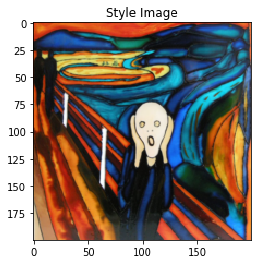

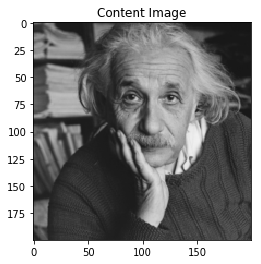

In [5]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# №6 Основная магия

Далее описана, реализующая Style Transfer. Основная магия происходит здесь. 

Посмотрите, какая математика стоит за данным алгоритмом, как и почему работает то, что написано ниже: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html. 

Еще несколько лет обучения в школе и ВУЗе и вы это точно поймете, и обязательно сможете делать более крутые вещи.

In [0]:
def StyleTransfer(content_img,style_img,device):
    device = torch.device("cpu")
    class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input
    def gram_matrix(input):
        a, b, c, d = input.size()  # a=batch size(=1)
        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product
        return G.div(a * b * c * d)
    class StyleLoss(nn.Module):

        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std
    # desired depth layers to compute style/content losses :
    content_layers_default = ['conv_4']
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)
        content_losses = []
        style_losses = []
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses
    input_img = content_img.clone()
    plt.figure()
    imshow(input_img, title='Input Image')
    def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        return optimizer
    def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=300,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_img)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    print('optimized')
    plt.figure()
    imshow(output, title='Output Image')

    plt.ioff()
    plt.show()
    unloader = transforms.ToPILImage()  
    
    image = output.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    image.save('output.png')

А теперь вы можете заменить ниже имена файлов на другие, которые вы захотите, и получить любое изображение в любом стиле. 

Обратите внимание на то, как уменьшаются параметры Style Loss и Content Loss — те самые расстояния генерируемого изображения до стиля и до исходного изображения.

# №7 Модуль загрузки собственных изображений

In [0]:
#!wget URL
#!wget URL
#!wget URL
#!wget URL
#!wget URL
#!wget URL
#!wget URL

# №8 Запуск нейронной сети

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:08<00:00, 68302828.66it/s]


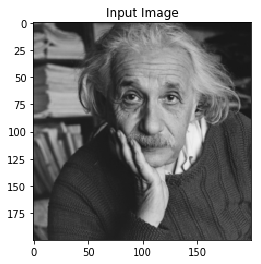

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 149.953003 Content Loss: 62.076496

run [100]:
Style Loss : 44.774242 Content Loss: 59.622494

run [150]:
Style Loss : 21.054855 Content Loss: 56.142082

run [200]:
Style Loss : 12.531528 Content Loss: 52.819889

run [250]:
Style Loss : 8.686294 Content Loss: 49.915966

run [300]:
Style Loss : 6.853385 Content Loss: 47.391636

optimized


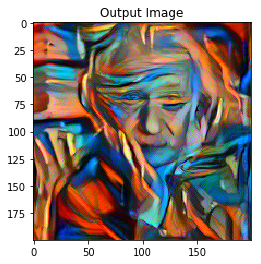

In [8]:
style_img = image_loader("scream.jpg")
content_img = image_loader("emc.jpg")

StyleTransfer(content_img, style_img, device)